# Use the GitHub API to visualize project contributions

In [1]:
import os
import re

import pandas
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

## Utilities for querying the GitHub API

In [2]:
def query(format_url, **kwargs):
    url = format_url.format(**kwargs)
    response = requests.get(url)
    obj = response.json()
    df = pandas.DataFrame(obj)
    return df

def concat_queries(format_url, kwargs_list):
    dfs = list()
    for kwargs in kwargs_list:
        df = query(format_url, **kwargs)
        for key, value in kwargs.items():
            df[key] = value
        dfs.append(df)
    return pandas.concat(dfs)

## Retrieve contribution data

In [3]:
repo_df = query('https://api.github.com/orgs/cognoma/repos')
repo_df.name.tolist()

['cognoma',
 'core-service',
 'task-service',
 'cancer-data',
 'machine-learning',
 'sandbox',
 'frontend',
 'cognoma.github.io',
 'uiux',
 'ml-workers',
 'genes',
 'cognoml',
 'figshare']

In [4]:
format_url = 'https://api.github.com/repos/cognoma/{repo_name}/contributors'
kwargs_list = [{'repo_name': repo} for repo in repo_df.name]
contrib_df = concat_queries(format_url, kwargs_list)

## Contribution count heatmap: repository versus user

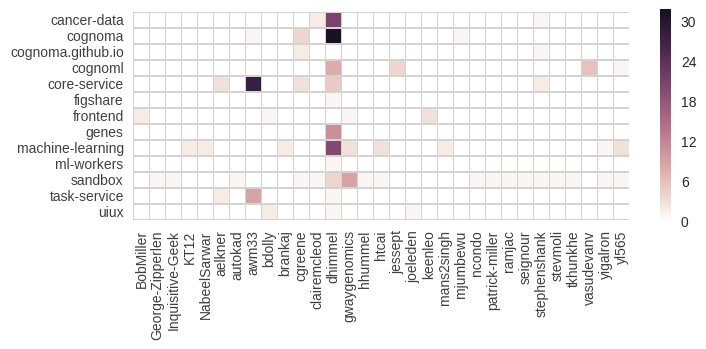

In [5]:
contrib_plot_df = (contrib_df
    .pivot_table('contributions', 'repo_name', 'login', fill_value=0)
)
cmap = seaborn.cubehelix_palette(light=1, as_cmap=True, gamma=1.3)
ax = seaborn.heatmap(contrib_plot_df, square=True, linewidths=0.5, cmap=cmap, linecolor='#d3d3d3')
#ax.xaxis.set_ticks_position('top')
#ax.xaxis.set_label_position('top')
plt.xticks(rotation=90, color='#3f3f3f')
plt.yticks(color='#3f3f3f')
plt.ylabel('')
plt.xlabel('')
fig = ax.get_figure()
fig.set_size_inches(w=8, h=2.75)
fig.savefig('contribution-heatmap.png', dpi=200, bbox_inches='tight')
fig.savefig('contribution-heatmap.svg', bbox_inches='tight')

In [6]:
# Save user-by-repo contribution count data
contrib_plot_df.transpose().to_csv('contribution-by-repo.tsv', sep='\t')

## Create a total contribution summary table

In [7]:
# Extract maintainers from the repository README
path = os.path.join('..', 'README.md')
with open(path) as read_file:
    readme = read_file.read()

pattern = r'@\*\*(.+?)\*\*'
maintainers = re.findall(pattern, readme)
maintainers = sorted(set(maintainers))
maintainer_df = pandas.DataFrame({'login': maintainers, 'maintainer': 1})
maintainer_df.head(2)

,login,maintainer
0,KarinSpiderwoman,1
1,awm33,1


In [8]:
# Total contributions per user excluding sandbox
summary_df = (contrib_plot_df
    .query("repo_name != 'sandbox'")
    .sum(axis='rows')
    .rename('contributions')
    .reset_index()
    .query('contributions > 0')
    .merge(maintainer_df, how='outer')
    .fillna(0)
    .sort_values(['maintainer', 'contributions', 'login'], ascending=[False, False, True])
)

for column in 'contributions', 'maintainer':
    summary_df[column] = summary_df[column].astype(int)

summary_df.to_csv('contributor-summary.tsv', sep='\t', index=False)
summary_df.head(2)

,login,contributions,maintainer
9,dhimmel,101,1
4,awm33,38,1
